<a href="https://colab.research.google.com/github/Z0rr09/OD-WeaponDetection/blob/master/Notebook_module_6%20V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries:
We'll start by importing the necessary libraries. For this project, we'll need libraries such as PyTorch, torchvision, matplotlib, NumPy, and others.

In [49]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

### Set Device:
We'll set the device to GPU if available, otherwise, we'll use the CPU.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define Dataset Paths: We'll specify the paths to the image and annotation folders containing the dataset.

In [3]:
!git clone https://github.com/Z0rr09/OD-WeaponDetection.git
image_folder = '/content/OD-WeaponDetection/Pistol detection/Weapons'
annotation_folder = '/content/OD-WeaponDetection/Pistol detection/xmls'



fatal: destination path 'OD-WeaponDetection' already exists and is not an empty directory.


###Define Transform:
We'll define the transformations to apply to the images before feeding them into the model.

In [109]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [114]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [115]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [52]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size if needed
    transforms.ToTensor(),
])

In [116]:
# Convert word label to int.
label_dict = {'pistol': 1, 'smartphone': 2, 'knife': 3, 'monedero': 4, 'billete': 5, 'tarjeta': 6}
# Convert label int to word .
reverse_label_dict = {1:'pistol', 2:'smartphone', 3:'knife', 4:'monedero', 5:'billete',6:'tarjeta'}

In this code:

We define a custom dataset class WeaponDataset that loads images and their corresponding annotations from the specified folders.
We use the Image module from PIL to load images and parse XML annotations using xml.etree.ElementTree.
The dataset class provides __len__ and __getitem__ methods to support indexing and iteration over the dataset.
When creating an instance of WeaponDataset, we pass the paths to the image and annotation folders, along with the specified transformation.
Finally, we demonstrate an example usage of the dataset by accessing an image and its corresponding targets.




In [118]:
# Custom dataset class
class WeaponDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform
        self.image_names = [name for name in os.listdir(image_folder) if name.lower().endswith('.jpg')]
        self.annot_names = [name for name in os.listdir(annotation_folder) if name.lower().endswith('.xml')]
        print(f"Found {len(self.image_names)} images.")
        print(f"Found {len(self.annot_names)} annot.")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_names[idx])
        annotation_name = os.path.join(self.annotation_folder, os.path.splitext(self.image_names[idx])[0] + '.xml')
        image = Image.open(img_name).convert('RGB')
        targets = self.parse_annotation(annotation_name)
        if self.transform:
            self.transform(image, targets)

        return image, targets

    def parse_annotation(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labeltext = obj.find('name').text
            labels.append(label_dict[labeltext])
        return {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.as_tensor(labels,dtype = torch.int64)}

# Create dataset instance
dataset = WeaponDataset(image_folder, annotation_folder, get_transform(train = True))

# Example usage of the dataset
image, targets = dataset[0]
print("Image shape:", image)
print("Targets:", targets)

Found 3000 images.
Found 3000 annot.
Image shape: <PIL.Image.Image image mode=RGB size=1500x1125 at 0x7FA72C816170>
Targets: {'boxes': tensor([[ 224.,  260., 1247.,  930.]]), 'labels': tensor([1])}


Define Function to Show Bounding Boxes: We'll write a function to visualize bounding boxes on images.

In [119]:
def show_image_with_boxes(image, target):
    plt.figure(figsize=(8, 6))
    image = image[0].permute(1, 2, 0).numpy()
    plt.imshow(image)
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')
    plt.axis('off')
    plt.show()

In [121]:
def show_image_with_boxes(image, target):
    fig, ax = plt.subplots(figsize=[5, 5])
    #ax.imshow(image[0].permute(1, 2, 0).numpy())
    image.show
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')
    plt.axis('off')
    plt.show()

Parse XML Annotations: We'll implement a function to parse XML annotation files associated with each image, extracting bounding box coordinates and class labels.

In [81]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_dict[obj.find('name').text])
    return {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.as_tensor(labels,dtype = torch.int64)}


Custom Collate Function: We'll define a custom collate function to preprocess the data and annotations before passing them to the model.

In [91]:
def collate_ari(batch, transform=None):
    images = []
    targets = []
    for image, annotation in batch:

        # Apply transformations if provided
        if transform is not None:
            image, annotation = transform(image,annotation)
        targets.append(annotation)
        images.append(image)

    return images, targets


In [39]:
def collate_fn(batch, transform=None):
    images = []
    targets = []
    for image_path, annotation_path in batch:
        # Load image
        image = Image.open(image_path).convert("RGB")
        # Apply transformations if provided
        if transform is not None:
            image = transform(image)
        images.append(image)

        # Parse annotation (assuming this function is defined elsewhere)
        annotation = parse_annotation(annotation_path)
        targets.append(annotation)

    return images, targets

Create DataLoader: We'll create a DataLoader to iterate over the dataset in batches, utilizing the custom collate function.

In [92]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_ari)

subset_indices = torch.randperm(len(dataset))[:100]  # Load 100 samples as a subset
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)
subset_data_loader = DataLoader(subset_dataset, batch_size=2, shuffle=True, collate_fn=collate_ari)

In [96]:
# Example usage of the data loader
for images, targets in data_loader:
    print("Batch size:", len(images))
    print("target size:", len(targets))
    print("Image shape:", type(images[0]))
    print("Targets:", targets)
    break  # Only print the first batch

Batch size: 2
target size: 2
Image shape: <class 'PIL.Image.Image'>
Targets: [{'boxes': tensor([[136.,  53., 218., 134.]]), 'labels': tensor([1])}, {'boxes': tensor([[ 15.,  24., 286., 147.]]), 'labels': tensor([1])}]


Load Pre-trained Model: We'll load a pre-trained Faster R-CNN model using the fasterrcnn_resnet50_fpn function from torchvision.models.detection.

In [86]:
model = fasterrcnn_resnet50_fpn( weights='DEFAULT')
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Define Optimizer and Loss Function: We'll define the optimizer and loss function for training the model. For this example, let's use the SGD optimizer and the Smooth L1 loss.

In [87]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
loss_function = torch.nn.SmoothL1Loss()


Function to Show Example Photos: We'll create a function to randomly select and display a few example photos from the dataset.

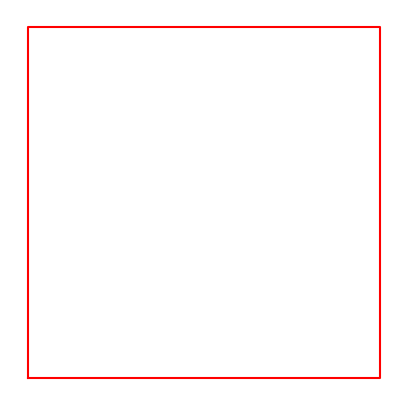

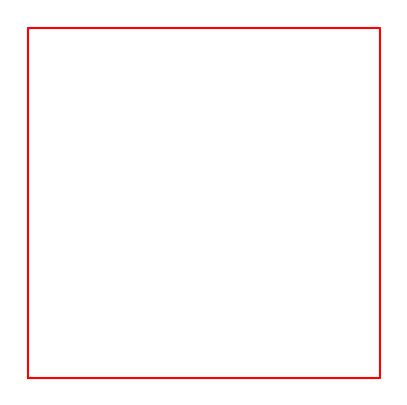

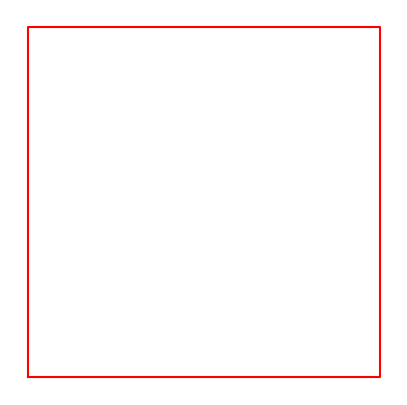

In [124]:
def show_example_photos(dataset, num_photos=3):
    indices = torch.randperm(len(dataset))[:num_photos]
    for idx in indices:
        image, target = dataset[idx]
        show_image_with_boxes(image, target)
show_example_photos(dataset)

In [123]:
for images, targets in subset_data_loader:
    print(len(images))  # Print the shape of the images tensor
    print(len(targets))  # Print the targets
    break  # Only print the first batch to avoid overwhelming output


2
2


Training Loop: We'll implement a training loop to train the model on the subset of the dataset, iterating over the DataLoader and optimizing the model parameters.

In [125]:
import torch

def train(model, optimizer, loss_function, data_loader, device, num_epochs=2):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0.0

        for images, targets in data_loader:

            # Move images to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in target.items()} for target in targets]
            optimizer.zero_grad()
            # Model expects tensors as input, not PIL images
            output = model(images, targets)
            # Assuming your loss function can handle the model's output and the targets
            loss = loss_function(output, targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, optimizer, loss_function, subset_data_loader, device)


AttributeError: to

Visualize Sample Prediction: We'll visualize a sample prediction by making inference on a single image from the dataset and displaying the original image with predicted bounding boxes.

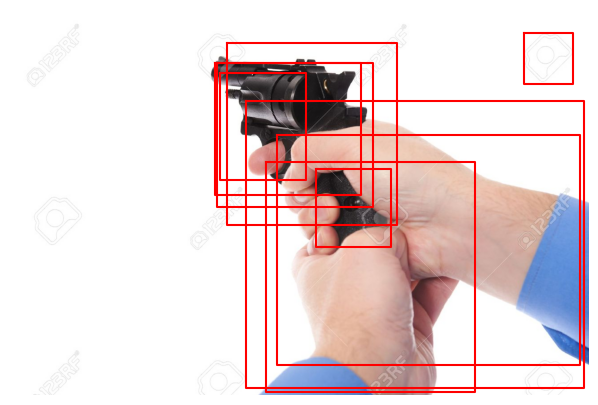

In [ ]:
def visualize_prediction(model, dataset):
    idx = torch.randint(len(dataset), (1,)).item()
    image, target = dataset[idx]
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])
    model.train()

    image = image.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    for box in prediction[0]['boxes']:
        xmin, ymin, xmax, ymax = box.cpu().numpy()
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='r')
    plt.axis('off')
    plt.show()

visualize_prediction(model, dataset)


Model Evaluation: We'll implement a function to evaluate the model's performance on a separate validation or test dataset. We'll compute relevant metrics such as precision, recall, F1-score, and mean average precision (mAP) for object detection tasks.

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            predictions = model(images)
            all_predictions.extend(predictions)
            all_targets.extend(targets)

    # Compute evaluation metrics (e.g., precision, recall, F1-score, mAP)
    # You can use libraries like scikit-learn or torchvision's ObjectDetectionMetric
    # to compute these metrics
    # Example:
    # mAP = compute_mean_average_precision(all_predictions, all_targets)
    # precision, recall, f1_score = compute_precision_recall_f1(all_predictions, all_targets)

    # Print or log the evaluation results
    # print(f"mAP: {mAP}, Precision: {precision}, Recall: {recall}, F1-score: {f1_score}")


Save and Load Model: We'll add functionality to save trained models to disk and load them for inference or further training. This allows for easy model deployment and reuse without retraining from scratch.

In [ ]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()


Model Interpretability: We'll explore methods for interpreting and visualizing model predictions, such as class activation maps or occlusion sensitivity. This can provide insights into the model's decision-making process and help diagnose errors.

In [ ]:
# Example function for generating class activation maps (CAM)
# Requires modification to adapt to the specific model architecture
def generate_cam(model, image):
    # Forward pass through the model to obtain feature maps
    feature_maps = model.backbone(image.unsqueeze(0))

    # Perform global average pooling on the feature maps
    pooled_features = torch.mean(feature_maps, dim=[2, 3])

    # Perform linear transformation to obtain class activation map (CAM)
    cam = model.roi_heads.box_predictor.cls_score(pooled_features)

    # Normalize CAM
    cam = torch.nn.functional.interpolate(cam, size=image.shape[-2:], mode='bilinear', align_corners=False)
    cam = torch.nn.functional.softmax(cam, dim=1)

    return cam


Pipeline Optimization: We'll profile the codebase to identify bottlenecks or areas for optimization, such as data loading, model inference, or gradient computation. We can then optimize these components to improve overall training speed and efficiency.

In [ ]:
# Example: Profile data loading time
import time
start_time = time.time()
# Code for data loading
end_time = time.time()
print(f"Data loading time: {end_time - start_time} seconds")


Experiment Tracking: We'll incorporate tools or libraries for experiment tracking and logging, such as TensorBoard or Weights & Biases. This allows for better monitoring of training progress, visualization of metrics, and comparison of different experiments.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter()

# Inside the training loop, log metrics
writer.add_scalar('Loss/train', total_loss/len(data_loader), epoch)

# After training, close the writer
writer.close()


Data Augmentation: We'll explore data augmentation techniques to increase the diversity of training data and improve model generalization. This could include random rotations, flips, crops, or color jittering.

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

Modularization: We'll break down the code into modular functions or classes to improve readability, reusability, and maintainability. For example, separate the data loading, model definition, training loop, and evaluation into distinct functions or classes.

In [ ]:
class WeaponDetectionModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(WeaponDetectionModel, self).__init__()
        # Define model architecture

    def forward(self, images, targets=None):
        # Forward pass

    def evaluate(self, data_loader):
        # Evaluation logic

    def train_step(self, optimizer, loss_function, images, targets):
        # Training logic

model = WeaponDetectionModel(num_classes)


Hyperparameter Tuning: We'll automate hyperparameter tuning using techniques like grid search or random search to find optimal hyperparameters for the model. This can improve model performance and convergence speed.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define parameters grid
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'momentum': [0.9, 0.95, 0.99],
    'weight_decay': [0.0001, 0.0005, 0.001]
}

# Define custom scoring function (e.g., mean average precision)
def custom_scorer(model, X, y_true):
    y_pred = model.predict(X)
    return compute_mean_average_precision(y_pred, y_true)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=make_scorer(custom_scorer), cv=5)


Fine-tuning Pre-trained Model: We'll fine-tune the pre-trained model on our dataset to adapt it to our specific task. This involves freezing certain layers and only updating the parameters of the final layers during training.

In [ ]:
# Example: Fine-tuning by freezing backbone layers
for param in model.backbone.parameters():
    param.requires_grad = False


Early Stopping: We'll implement early stopping to prevent overfitting and improve generalization. This involves monitoring a validation metric (e.g., validation loss or accuracy) and stopping training when the metric stops improving.


In [ ]:

best_loss = float('inf')
patience = 3
early_stopping_counter = 0

for epoch in range(num_epochs):
    # Training loop
    # ...

    # Validation loop
    # Compute validation loss
    val_loss = compute_validation_loss(model, val_data_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        save_model(model, 'best_model.pth')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered!")
        break


Learning Rate Scheduler: We'll use a learning rate scheduler to dynamically adjust the learning rate during training, potentially improving convergence and final performance.

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
# Inside the training loop
scheduler.step()


Model Ensemble: We can explore the concept of model ensemble, where multiple models are trained independently and their predictions are combined to make a final decision. This can often improve performance compared to using a single model.

In [ ]:
# Example of simple model averaging ensemble
def ensemble_predictions(models, data_loader):
    all_predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            predictions = []
            for images, _ in data_loader:
                images = [image.to(device) for image in images]
                predictions.extend(model(images))
        all_predictions.append(predictions)
    return all_predictions

def combine_predictions(predictions):
    # Combine predictions (e.g., average or majority voting)
    # Return final combined predictions


Data Balancing: If the dataset is imbalanced (e.g., more negative samples than positive samples), we can apply techniques for data balancing such as oversampling, undersampling, or using class weights during training to mitigate the imbalance.

In [ ]:
# Example: Use class weights in the loss function
class_weights = compute_class_weights(targets)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)


Model Deployment: Once the model is trained and evaluated, we can deploy it for inference in real-world scenarios. This involves packaging the model into a format suitable for deployment (e.g., ONNX, TorchScript) and integrating it into an application or service.

In [ ]:
# Example: Export model to ONNX format
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, 'model.onnx', input_names=['input'], output_names=['output'])


In [ ]:
# Install necessary libraries
#!pip install torch torchvision

# Import libraries
import torch
from torchvision import transforms, datasets
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define dataset paths
image_folder = "https://github.com/ari-dasci/OD-WeaponDetection/raw/main/Pistol%20detection/Weapons"
annotation_folder = "https://github.com/ari-dasci/OD-WeaponDetection/raw/main/Pistol%20detection/xmls"

# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.VOCDetection(root=image_folder, year='2007', image_set='train', download=True, transform=transform)

In [ ]:
#Get a few Example of database
def show_bbox(image_path):
  # convert image path to label path
  label_path = image_path.replace('/images/', '/labels/')
  label_path = label_path.replace('.jpg', '.txt')
  # Open the image and create ImageDraw object for drawing
  image = Image.open(image_path)
  draw = ImageDraw.Draw(image)
  print(image)
  with open(label_path, 'r') as f:
    for line in f.readlines():
      # Split the line into five values
      label, x, y, w, h = line.split(' ')

      # Convert string into float
      x = float(x)
      y = float(y)
      w = float(w)
      h = float(h)

      # Convert center position, width, height into
      # top-left and bottom-right coordinates
      W, H = image.size
      x1 = (x - w/2) * W
      y1 = (y - h/2) * H
      x2 = (x + w/2) * W
      y2 = (y + h/2) * H

      # Draw the bounding box with red lines
      draw.rectangle((x1, y1, x2, y2),outline=(255, 0, 0), width=5)# Line width
  return image


In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision import transforms

def parse_xml_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image path
    image_path = root.find('path').text

    # Extract object bounding box coordinates and class labels
    boxes = []
    labels = []
    for obj in root.findall('object'):
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        label = obj.find('name').text
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return image_path, boxes, labels

def my_collate(batch):
    images = []
    targets = []

    for xml_file in batch:
        # Parse XML annotation file
        image_path, boxes, labels = parse_xml_annotation(xml_file)

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        transform = transforms.Compose([
            transforms.Resize((500, 500)),
            transforms.ToTensor(),
        ])
        image = transform(image)

        images.append(image)
        targets.append({'boxes': boxes, 'labels': labels})

    return torch.stack(images), targets




In [ ]:
# Example usage:
annotation_folder = "/content/OD-WeaponDetection/OD-WeaponDetection-master/Pistol detection/xmls"
xml_files = [os.path.join(annotation_folder, file) for file in os.listdir(annotation_folder)]

data_loader = DataLoader(xml_files, batch_size=16, shuffle=True, collate_fn=my_collate)



# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn( weights='DEFAULT')
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
criterion = torch.nn.SmoothL1Loss()

In [ ]:
################################# Get a few examples of Photos to present ####################################
base_Directory = "/content/drive/MyDrive/DeepLData/obj_train_data/images/train/"
all_files = os.listdir(base_Directory)
image_Paths = []

#Get 9 images randomly to see some images (train)
for i in range(9):
  img = random.choice(all_files)
  img_Path = base_Directory + img
  image_Paths.append(img_Path)

#Create Subplots axes to present data
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

#Images to train the data
for i, (ax, image_path) in enumerate(zip(axes, image_Paths)):
  img = show_bbox(image_path)
  ax.imshow(img)

In [ ]:

# Load dataset with a subset
subset_size = 500  # Change this to the desired subset size
subset_dataset = datasets.VOCDetection(root=image_folder, year='2007', image_set='train', download=True, transform=transform)
subset_dataset = torch.utils.data.Subset(subset_dataset, range(subset_size))

# Define data loader with custom collate function
subset_data_loader = DataLoader(subset_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=my_collate)

In [ ]:
# ... (previous code)

# Training loop (light training for demonstration purposes)
num_epochs = 50
for epoch in range(num_epochs):
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)

        # Modify targets to include necessary keys (assuming bounding box annotations and labels)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        for target in targets:
            if "boxes" not in target:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32, device=device)
            if "labels" not in target:
                target["labels"] = torch.zeros((0,), dtype=torch.int64, device=device)

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

# ... (continue with the rest of the script)


In [ ]:
# Visualize a sample prediction
model.eval()
with torch.no_grad():
    sample_image, sample_target = dataset[0]
    sample_image = sample_image.unsqueeze(0).to(device)
    prediction = model([sample_image])[0]

# Display the original image and the predicted bounding boxes
image = F.to_pil_image(sample_image.cpu().squeeze())
draw = ImageDraw.Draw(image)
draw.rectangle(prediction['boxes'][0].cpu().numpy(), outline="red")

plt.imshow(image)
plt.show()


In [ ]:
import os
import requests
import zipfile
from io import BytesIO

# Define the GitHub repository URL
repo_url = 'https://github.com/ari-dasci/OD-WeaponDetection/archive/master.zip'

# Download the zip file from GitHub
response = requests.get(repo_url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Specify the target directory in Colab
target_dir = '/content/OD-WeaponDetection'

# Extract the contents of the zip file to the target directory
zip_file.extractall(target_dir)

# Identify the actual directory containing the dataset
dataset_dir = os.path.join(target_dir, 'OD-WeaponDetection-master', 'Pistol detection')

# Print the contents of the dataset directory
print(os.listdir(dataset_dir))




['Weapons', 'xmls']


In [ ]:


# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define root directory
root_dir = '/content/OD-WeaponDetection/OD-WeaponDetection-master/Pistol detection'

# Define paths to your dataset
images_dir = os.path.join(root_dir, 'Weapons')
annotations_dir = '/content/OD-WeaponDetection/OD-WeaponDetection-master/Pistol detection/xmls'

# Image parameters
img_height, img_width = 150, 150
batch_size = 32

# Create a list of image files
image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.jpg')]

# Create a list of annotation files
annotation_files = [os.path.join(annotations_dir, file) for file in os.listdir(annotations_dir) if file.endswith('.xml')]

# Ensure that corresponding image and annotation files exist
image_files = [file for file in image_files if os.path.splitext(file)[0] + '.xml' in annotation_files]

# Split the dataset into training and testing sets
train_image_files, test_image_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_list(
    train_image_files,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_list(
    test_image_files,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Training loop (light training for demonstration purposes)
num_epochs = 2
for epoch in range(num_epochs):
    for images, targets in subset_data_loader:
        images = list(image.to(device) for image in images)

        # Modify targets to include necessary keys (assuming bounding box annotations and labels)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        for target in targets:
            if "boxes" not in target:
                target["boxes"] = torch.zeros((0, 4), dtype=torch.float32, device=device)
            if "labels" not in target:
                target["labels"] = torch.zeros((0,), dtype=torch.int64, device=device)

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

# ... (continue with the rest of the script

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "<ipython-input-21-8b1c1f8db139>", line 33, in my_collate
    image_path, boxes, labels = parse_xml_annotation(xml_file)
  File "<ipython-input-21-8b1c1f8db139>", line 7, in parse_xml_annotation
    tree = ET.parse(xml_file)
  File "/usr/lib/python3.10/xml/etree/ElementTree.py", line 1222, in parse
    tree.parse(source, parser)
  File "/usr/lib/python3.10/xml/etree/ElementTree.py", line 569, in parse
    source = open(source, "rb")
TypeError: expected str, bytes or os.PathLike object, not tuple


ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([1, 3, 333, 500])

In [ ]:
# ... (previous code)

# Evaluation loop
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        prediction = model(images)
        all_predictions.extend(prediction)
        all_targets.extend(targets)

# Calculate Average Precision
from sklearn.metrics import average_precision_score

y_true = []
y_scores = []

for target, prediction in zip(all_targets, all_predictions):
    # Convert box coordinates to numpy arrays for easier handling
    target_boxes = target['boxes'].cpu().numpy()
    prediction_boxes = prediction['boxes'].cpu().numpy()

    # Calculate IoU (Intersection over Union) between target and prediction boxes
    iou = calculate_iou(target_boxes, prediction_boxes)

    # Determine true positives (IoU > threshold)
    true_positives = (iou > 0.5).sum()

    # Append ground truth and prediction information
    y_true.append(torch.ones(true_positives))
    y_true.append(torch.zeros(len(target_boxes) - true_positives))

    y_scores.append(prediction['scores'])
    y_scores.append(torch.zeros(len(target_boxes) - true_positives))

y_true = torch.cat(y_true)
y_scores = torch.cat(y_scores)

# Calculate Average Precision using sklearn
average_precision = average_precision_score(y_true.numpy(), y_scores.numpy())
print(f'Average Precision: {average_precision}')

# Visualize predictions on a few test images
model.eval()
with torch.no_grad():
    for i in range(3):  # Visualize predictions for the first 3 images
        sample_image, sample_target = dataset[i]
        sample_image = sample_image.unsqueeze(0).to(device)
        prediction = model([sample_image])[0]

        # Display the original image and the predicted bounding boxes
        image = F.to_pil_image(sample_image.cpu().squeeze())
        draw = ImageDraw.Draw(image)

        for box, score in zip(prediction['boxes'], prediction['scores']):
            if score > 0.5:  # Confidence threshold
                draw.rectangle(box.cpu().numpy(), outline="red")

        plt.imshow(image)
        plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Rob\\Desktop\\Definitiva\\armas (1006).jpg'